In [2]:
# IMPORT LIBRARIES
##################

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings('ignore')

In [3]:
# VISUAL SETTINGS
##################

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

In [4]:
# LOADING CSV
##################

def load_latest_csv(data_dir='data', rename_files=False):
    """Load the most recent CSV file from the data directory"""
    files = [
        os.path.join(data_dir, f)
        for f in os.listdir(data_dir)
        if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')
    ]

    sorted_files = sorted(files, key=os.path.getctime, reverse=True)

    for file_path in sorted_files:
        created_at = datetime.fromtimestamp(os.path.getctime(file_path))
        timestamp_str = created_at.strftime('%Y-%m-%d_%H-%M-%S')
        original_name = os.path.basename(file_path)
        new_name = f"{timestamp_str}_{original_name}"
        new_path = os.path.join(data_dir, new_name)

        if rename_files:
            if not original_name.startswith(timestamp_str):
                os.rename(file_path, new_path)
                print(f"Renamed: {original_name} → {new_name}")
                file_path = new_path
            else:
                print(f"Already renamed: {original_name}")
        else:
            print(f"[DEV] Would rename: {original_name} → {new_name}")

    return pd.read_csv(sorted_files[0])

# Load data
df_raw = load_latest_csv()

[DEV] Would rename: data.csv → 2025-06-02_13-30-33_data.csv
[DEV] Would rename: DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv → 2025-05-29_18-44-09_DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv


In [5]:
# DATA PREPROCESSING
##################

def preprocess_data(df):
    """Clean and preprocess the subscription data"""
    df = df.copy()

    # Date conversion
    date_cols = [col for col in df.columns if '(UTC)' in col]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

    df = df.sort_values(by='Created (UTC)')

    # Column selection and renaming
    columns_to_keep = [
        'Customer Name', 'Status', 'Cancellation Reason',
        'Created (UTC)', 'Start (UTC)', 'Start Date (UTC)', 
        'Current Period Start (UTC)', 'Current Period End (UTC)', 
        'Trial Start (UTC)', 'Trial End (UTC)',
        'Canceled At (UTC)', 'Ended At (UTC)', 
        'senderShopifyCustomerId (metadata)'
    ]
    
    df = df[columns_to_keep]

    df.rename(columns={
        'Customer ID': 'customer_id',
        'Customer Name': 'customer_name',
        'Status': 'status',
        'Cancellation Reason': 'cancellation_reason',
        'Created (UTC)': 'created_utc',
        'Start (UTC)': 'start_utc',
        'Start Date (UTC)': 'start_date_utc',
        'Current Period Start (UTC)': 'current_period_start_utc',
        'Current Period End (UTC)': 'current_period_end_utc',
        'Trial Start (UTC)': 'trial_start_utc',
        'Trial End (UTC)': 'trial_end_utc',
        'Canceled At (UTC)': 'canceled_at_utc',
        'Ended At (UTC)': 'ended_at_utc',
        'senderShopifyCustomerId (metadata)': 'is_gifted_member'
    }, inplace=True)

    # Convert is_gifted_member to boolean
    df['is_gifted_member'] = df['is_gifted_member'].notna() 

    # Reference date for analysis
    reference_date = pd.Timestamp.now(tz='UTC')
    print(f"📅 Reference date (TODAY) for analysis: {reference_date.strftime('%d-%m-%Y')}")

    # Consolidate status
    df.loc[df['status'].isin(['past_due', 'incomplete_expired']), 'status'] = 'canceled'

    return df, reference_date

df, reference_date = preprocess_data(df_raw)

📅 Reference date (TODAY) for analysis: 02-06-2025


In [6]:
# HELPER FUNCTIONS
##################

def clean_membership_data(df):
    """Clean and prepare membership data for analysis"""
    # Remove very short subscriptions (likely test accounts)
    df['duration_days'] = (pd.to_datetime(df['ended_at_utc']) - pd.to_datetime(df['created_utc'])).dt.days
    
    # Keep accounts that are either:
    # 1. Longer than 1 day, OR
    # 2. Still active/trialing (even if recent)
    df_clean = df[~((df['duration_days'] < 1) & ~(df['status'].isin(['active', 'trialing'])))]
    
    # Remove duplicate signups (within 12 hours)
    df_clean = df_clean.sort_values(['customer_name', 'created_utc'], ascending=[True, False])
    df_clean['time_diff'] = df_clean.groupby('customer_name')['created_utc'].diff()
    
    # Remove duplicates but keep the most recent (due to descending sort)
    df_clean = df_clean[~((df_clean['time_diff'] < pd.Timedelta(hours=12)) & (df_clean['time_diff'].notna()))]
    df_clean = df_clean.sort_values('created_utc', ascending=True)
    
    return df_clean.drop(['duration_days', 'time_diff'], axis=1)



def calculate_real_duration(row):
    """Calculate actual subscription duration from signup to end/current"""
    # Always start from actual signup date
    start_date = row['created_utc']
    
    # End date logic based on account status
    if pd.notna(row['ended_at_utc']):
        # Account has ended (canceled, expired, etc.)
        end_date = row['ended_at_utc']
    elif row['status'] in ['canceled'] and pd.notna(row['canceled_at_utc']):
        # Edge case: canceled but no ended_at_utc
        end_date = row['canceled_at_utc']
    else:
        # Active account: use end of current period
        end_date = row['current_period_end_utc']
    
    return (end_date - start_date).days



def calculate_trial_duration(row):
    """Calculate trial duration in days"""
    if pd.notna(row['trial_start_utc']) and pd.notna(row['trial_end_utc']):
        start_date = row['trial_start_utc']
        end_date = row['trial_end_utc']
        return (end_date - start_date).days
    return 0

def calculate_period_duration(row):
    """Calculate current billing period duration"""
    if pd.notna(row['current_period_start_utc']) and pd.notna(row['current_period_end_utc']):
        return (row['current_period_end_utc'] - row['current_period_start_utc']).dt.days
    return np.nan

def calculate_unknown_period(row):
    """Calculate gap between signup and first billing period (onboarding time)"""
    if pd.notna(row['created_utc']) and pd.notna(row['current_period_start_utc']):
        return (row['current_period_start_utc'] - row['created_utc']).dt.days
    return 0



def categorize_duration(duration):
    """Categorize subscription durations into business-meaningful groups"""
    if duration <= 9:
        return "Early Cancellation (0-9 days)"
    elif 10 <= duration <= 24:
        return "10-day Trial + Refund (10-24 days)"
    elif 25 <= duration <= 34:
        return "20-day Trial + Refund (25-34 days)" 
    elif 35 <= duration <= 55:
        return "30-day Trial + Refund (35-55 days)"
    elif 360 <= duration <= 420:
        return "Annual Subscription (360-420 days)"
    elif 730 <= duration <= 770:
        return "Two Year Subscription (730-770 days)"
    else:
        return f"Other ({duration} days)"
    

def categorize_status_detailed(row):
    """Enhanced status categorization based on multiple fields"""
    status = row['status']
    has_cancellation_reason = pd.notna(row['cancellation_reason'])
    cancel_at_period_end = row.get('cancel_at_period_end', False)
    
    if status == 'canceled':
        return 'Canceled'
    elif status == 'active' and has_cancellation_reason:
        return 'Active - Pending Cancellation'
    elif status == 'active':
        return 'Active'
    elif status == 'trialing' and has_cancellation_reason:
        return 'Trial - Canceled'
    elif status == 'trialing':
        return 'Trial - Active'
    elif status == 'past_due':
        return 'Payment Issues'
    elif status == 'incomplete_expired':
        return 'Payment Failed'
    else:
        return status.title()

In [7]:
def analyze_subscription_patterns(df):
    """Main analysis function that applies all calculations"""
    print("Starting subscription analysis...")
    
    # Clean the data
    df_clean = clean_membership_data(df)
    print(f"Data cleaned: {len(df)} → {len(df_clean)} records")
    
    # Calculate all duration metrics
    df_clean['real_duration'] = df_clean.apply(calculate_real_duration, axis=1)
    df_clean['trial_duration'] = df_clean.apply(calculate_trial_duration, axis=1)
    
    # Calculate period metrics
    df_clean['period_duration'] = (
        pd.to_datetime(df_clean['current_period_end_utc']) - 
        pd.to_datetime(df_clean['current_period_start_utc'])
    ).dt.days
    
    df_clean['unknown_period'] = (
        pd.to_datetime(df_clean['current_period_start_utc']) - 
        pd.to_datetime(df_clean['created_utc'])
    ).dt.days
    
    # Apply categorizations
    df_clean['duration_category'] = df_clean['real_duration'].apply(categorize_duration)
    df_clean['status_detailed'] = df_clean.apply(categorize_status_detailed, axis=1)
    
    # Add helper flags
    df_clean['only_trial'] = df_clean['period_duration'] == df_clean['trial_duration']
    df_clean['has_trial'] = df_clean['trial_duration'] > 0
    df_clean['is_pending_cancellation'] = (
        (df_clean['status'] == 'active') & 
        pd.notna(df_clean['cancellation_reason'])
    )
    
    print("Analysis complete!")
    return df_clean

In [8]:
analysis_df['created_year'] = analysis_df['created_utc'].dt.year                     # Année
analysis_df['created_week_num'] = analysis_df['created_utc'].dt.isocalendar().week

NameError: name 'analysis_df' is not defined

In [9]:
# Example usage:

# Apply the analysis
analysis_df = analyze_subscription_patterns(df)

# View results
print("Duration Categories:")
print(analysis_df['duration_category'].value_counts())

print("\nDetailed Status:")
print(analysis_df['status_detailed'].value_counts())

print("\nTrial Analysis:")
print(f"Users with trials: {analysis_df['has_trial'].sum():,}")
print(f"Trial-only accounts: {analysis_df['only_trial'].sum():,}")
print(f"Pending cancellations: {analysis_df['is_pending_cancellation'].sum():,}")


Starting subscription analysis...
Data cleaned: 20443 → 17127 records
Analysis complete!
Duration Categories:
Annual Subscription (360-420 days)      6370
10-day Trial + Refund (10-24 days)      6256
Early Cancellation (0-9 days)           1936
Two Year Subscription (730-770 days)    1754
20-day Trial + Refund (25-34 days)       463
                                        ... 
Other (433 days)                           1
Other (84 days)                            1
Other (92 days)                            1
Other (81 days)                            1
Other (291 days)                           1
Name: duration_category, Length: 113, dtype: int64

Detailed Status:
Canceled                         10608
Active                            6114
Active - Pending Cancellation      252
Trial - Active                     139
Trial - Canceled                    14
Name: status_detailed, dtype: int64

Trial Analysis:
Users with trials: 15,313
Trial-only accounts: 7,736
Pending cancellations: 25

In [10]:
# Get full members count per week
full_members = analysis_df[
    (analysis_df['status'] == 'active') &
    (analysis_df['is_gifted_member'] == False)  # Changed 'false' string to False boolean
]

# Filter to Sep 2023 onwards and group by week
weekly_members = (
    full_members[full_members['created_utc'] >= '2023-09-01']
    .groupby(['created_year', 'created_week_num'])
    .size()
    .reset_index()  # Reset index to make plotting easier
)

print("Weekly New Full Member Count:")
print(weekly_members)

plt.figure(figsize=(15, 8))
plt.plot(range(len(weekly_members)), weekly_members[0], marker='o', linestyle='-', color='b')
plt.title('Weekly New Full Member Count')
plt.xlabel('Week Number')
plt.ylabel('Number of Full Members')
plt.grid(True)
plt.show()

KeyError: 'created_year'

Weekly Cumulative Full Member Count:
    created_year  created_week_num   0  cumulative_members
0           2023                39  74                  74
1           2023                40  54                 128
2           2023                41  74                 202
3           2023                42  68                 270
4           2023                43  72                 342
..           ...               ...  ..                 ...
82          2025                17  36                5668
83          2025                18  80                5748
84          2025                19  38                5786
85          2025                20  20                5806
86          2025                21   7                5813

[87 rows x 4 columns]


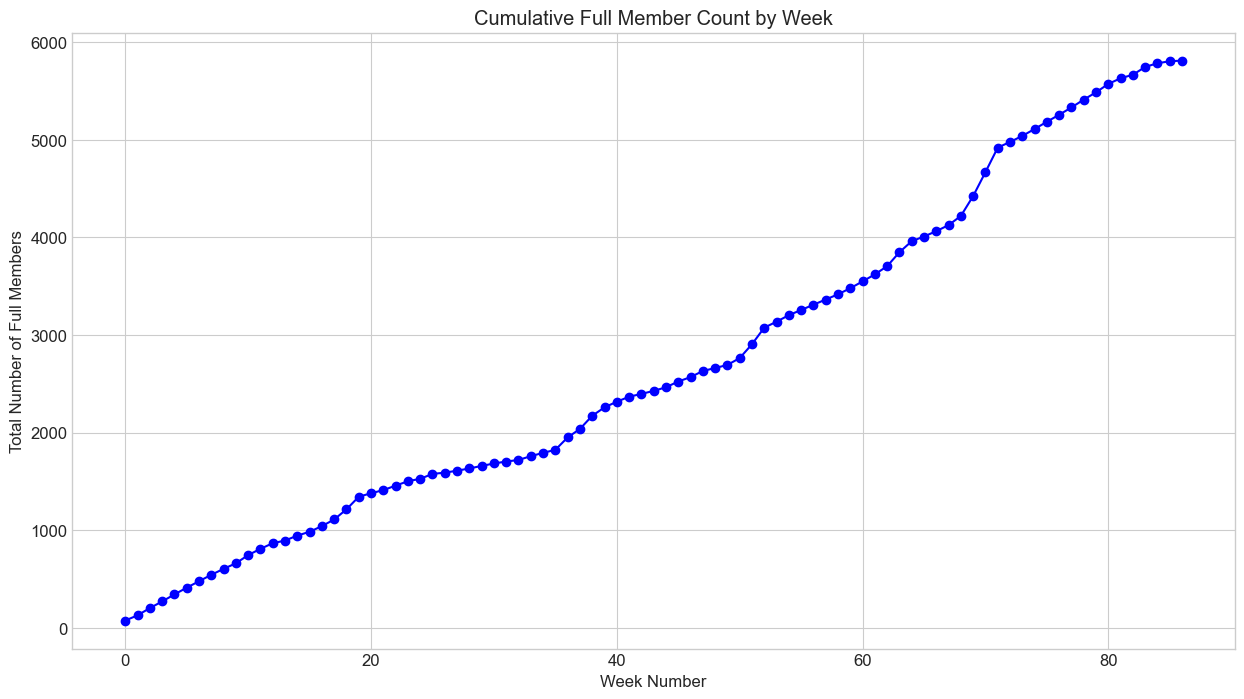

In [120]:
# Get full members count per week
full_members = analysis_df[
    (analysis_df['status'] == 'active') &
    (analysis_df['is_gifted_member'] == False)  # Changed 'false' string to False boolean
]

# Filter to Sep 2023 onwards and group by week
weekly_members = (
    full_members[full_members['created_utc'] >= '2023-09-01']
    .groupby(['created_year', 'created_week_num'])
    .size()
    .reset_index()  # Reset index to make plotting easier
)

# Calculate cumulative sum
weekly_members['cumulative_members'] = weekly_members[0].cumsum()

print("Weekly Cumulative Full Member Count:")
print(weekly_members)

plt.figure(figsize=(15, 8))
plt.plot(range(len(weekly_members)), weekly_members['cumulative_members'], marker='o', linestyle='-', color='b')
plt.title('Cumulative Full Member Count by Week')


plt.xlabel('Week Number')
plt.ylabel('Total Number of Full Members')
plt.grid(True)
plt.show()



In [121]:
analysis_df.columns


Index(['customer_name', 'status', 'cancellation_reason', 'created_utc',
       'start_utc', 'start_date_utc', 'current_period_start_utc',
       'current_period_end_utc', 'trial_start_utc', 'trial_end_utc',
       'canceled_at_utc', 'ended_at_utc', 'is_gifted_member', 'real_duration',
       'trial_duration', 'period_duration', 'unknown_period',
       'duration_category', 'status_detailed', 'only_trial', 'has_trial',
       'is_pending_cancellation', 'created_year', 'created_week_num'],
      dtype='object')

Weekly Churned Full Member Count:
Empty DataFrame
Columns: [created_year, created_week_num, 0]
Index: []


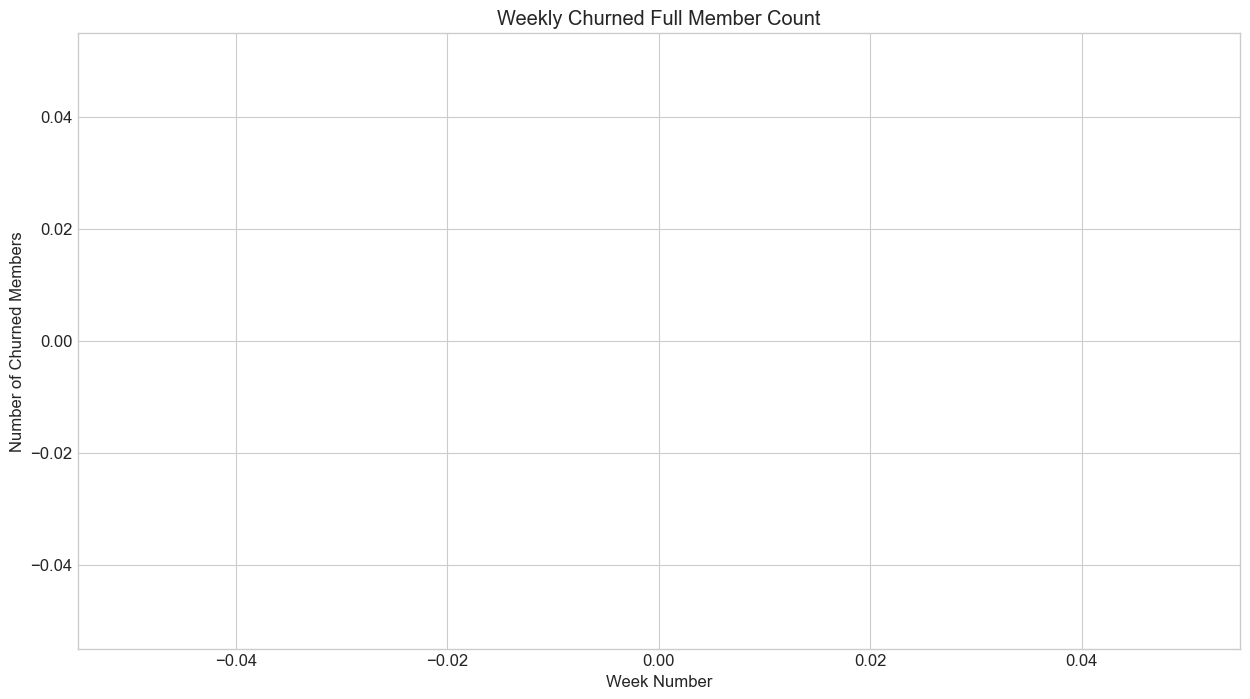

In [122]:
# Get churned members count per week
churned_members = analysis_df[
    (analysis_df['status'] == 'churned') &
    (analysis_df['is_gifted_member'] == False)  # Changed 'false' string to False boolean
]

# Filter to Sep 2023 onwards and group by week
weekly_churned = (
    churned_members[churned_members['created_utc'] >= '2023-09-01']
    .groupby(['created_year', 'created_week_num'])
    .size()
    .reset_index()  # Reset index to make plotting easier
)

print("Weekly Churned Full Member Count:")
print(weekly_churned)

plt.figure(figsize=(15, 8))
plt.plot(range(len(weekly_churned)), weekly_churned[0], marker='o', linestyle='-', color='r')
plt.title('Weekly Churned Full Member Count')
plt.xlabel('Week Number')
plt.ylabel('Number of Churned Members')
plt.grid(True)
plt.show()

In [123]:
analysis_df['duration_category'].value_counts()

Annual Subscription (360-420 days)      6370
10-day Trial + Refund (10-24 days)      6256
Early Cancellation (0-9 days)           1936
Two Year Subscription (730-770 days)    1754
20-day Trial + Refund (25-34 days)       463
                                        ... 
Other (433 days)                           1
Other (84 days)                            1
Other (92 days)                            1
Other (81 days)                            1
Other (291 days)                           1
Name: duration_category, Length: 113, dtype: int64

<Axes: >

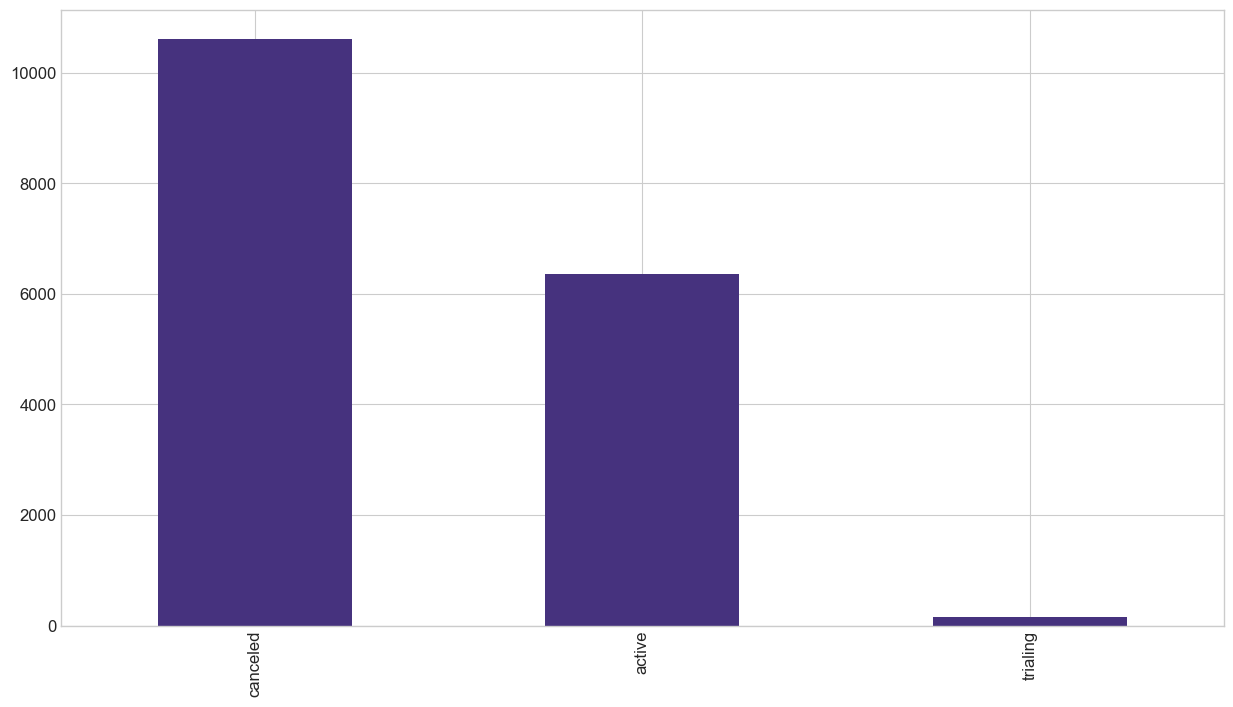

In [13]:
analysis_df['status'].value_counts().plot(kind='bar')